<a href="https://colab.research.google.com/github/hayden-huynh/CSE-5334-TermProject/blob/master/CSE_5334_TermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CSE 5334 - Data Mining: Term Project

## About The Project
- Dataset: [Top Reddit Posts and Comments](https://www.kaggle.com/datasets/tushar5harma/topredditcomments?select=Top_Posts.csv)
- Goal: Given a comment of a post, classify which subreddit (Machine Learning, Artificial Intelligence, or Data Science) that it belongs to
- Solution: Naive Bayes Classifier for Text Classification

## Project Steps
1. Download the Top Reddit Posts and Comments [dataset](https://www.kaggle.com/datasets/tushar5harma/topredditcomments?select=Top_Posts.csv) from Kaggle
2. Based on the original dataset, formulate a dataframe consisting of a column of **comment text**, and a column of subreddit class
3. Perform text pre-processing
  - Lower-casing
  - Punctuation removal
  - Tokenization and duplicate word removal
4. Split the data into ***train*** (70%), ***dev*** (20%), and ***test*** (10%) subsets
5. Train the Naive Bayes Classifier
6. Experiment for optimization with **dev** dataset
  - Smoothing
  - Stopword removal
  - Stemming / Lemmatization
7. Conclude final accuracy with **test** dataset


## Note about References
- The references used in a code block are placed as comments at the top of that block
- If some code lines are part of a reference, they will be wrapped around that reference. Otherwise, if code lines are not wrapped by any references, they are my own original codes

# Download the Dataset

In [1]:
# Download the Top Reddit Posts & Reviews dataset from Kaggle
# Reference 1 (Ref 1): https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/

# Ref 1 starts =====
! pip install kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download tushar5harma/topredditcomments
! unzip topredditcomments.zip
# ===== Ref 1 ends

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 90% 20.0M/22.1M [00:01<00:00, 19.6MB/s]
100% 22.1M/22.1M [00:01<00:00, 13.8MB/s]
Archive:  topredditcomments.zip
  inflating: Top_Posts.csv           
  inflating: Top_Posts_Comments.csv  


# Formulate Comment-Subreddit Dataframe

In [2]:
import pandas as pd
import numpy as np

top_posts = pd.read_csv("/content/Top_Posts.csv")
top_posts_comments = pd.read_csv("/content/Top_Posts_Comments.csv")

posts_id_class = top_posts[["post_id", "subreddit"]]

# Three classes: "MachineLearning", "datascience", "artificial"
comments = pd.merge(top_posts_comments, posts_id_class, on="post_id")

comments = comments[comments['comment'].notna()]

comments.sample(5)

,post_id,comment,subreddit
69205,aqwcyx,"> Pandora’s Box, once opened, can never be cl...",MachineLearning
11056,g4jc29,"Yes, I was bad stats joking back.",datascience
93121,g18xad,"Hey Drago,\n\nI am curious about the remote co...",MachineLearning
175616,qore0i,I did some of the labs when the topic was espe...,datascience
89416,42ymo8,"MCTS, Neural Networks trained from replays, Po...",MachineLearning


# Perform text pre-processing

In [11]:
# Reference 2 (Ref 2): https://www.analyticsvidhya.com/blog/2021/06/text-preprocessing-in-nlp-with-python-codes/
# Reference 3 (Ref 3): https://stackoverflow.com/questions/15586721/wordnet-lemmatization-and-pos-tagging-in-python
# Reference 4 (Ref 4): https://www.guru99.com/stemming-lemmatization-python-nltk.html#6

import string
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('tagsets')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

nltk_stopwords = stopwords.words("english")

# nltk.help.upenn_tagset()

# ---------- Lower-casing ----------
# Ref 2 starts =====
comments["comment"] = comments["comment"].apply(lambda c : c.lower())
# ===== Ref 2 ends

# ---------- Tokenization and Duplicate removal ----------
# Ref 2 starts =====
def tokenize(text):
  tokens = re.split("\W+", text)
# ===== Ref 2 ends
  tokens = list(filter(None, tokens))
  return sorted(list(set(tokens)))

# Ref 2 starts =====
comments["tokens"] = comments["comment"].apply(lambda c: tokenize(c))
# ===== Ref 2 ends

# ---------- Stopword removal ----------
# Ref 2 starts =====
def remove_stopwords(words):
  output = [w for w in words if w not in nltk_stopwords]
  return output
# ===== Ref 2 ends

# Ref 2 starts =====
# comments["tokens"] = comments["tokens"].apply(lambda words: remove_stopwords(words))
# ===== Ref 2 ends

# ---------- Punctuation removal ----------
# Ref 2 starts =====
def remove_punc_str(text):
  punc_free = "".join([char for char in text if char not in string.punctuation])
  return punc_free
# ===== Ref 2 ends

def remove_punc_arr(words):
  for i, w in enumerate(words):
    # Ref 2 starts =====
    punc_free = "".join([char for char in w if char not in string.punctuation])
    words[i] = punc_free
    # ===== Ref 2 ends
  return words

# Ref 2 starts =====
comments["tokens"] = comments["tokens"].apply(lambda c: remove_punc_arr(c))
# ===== Ref 2 ends

# ---------- Lemmatization ----------
lemmatizer = WordNetLemmatizer()

# Ref 3 starts =====
def get_wordnet_pos(tag: str):
  if tag.startswith("JJ"):
    return wordnet.ADJ
  elif tag.startswith("NN"):
    return wordnet.NOUN
  elif tag.startswith("RB"):
    return wordnet.ADV
  elif tag.startswith("V"):
    return wordnet.VERB
  else:
    return wordnet.NOUN
# ===== Ref 3 ends

def lemmatize_tokens(tokens):
  new_tokens = set()
  # Ref 4 starts =====
  for token, tag in nltk.pos_tag(tokens):
    lemma = lemmatizer.lemmatize(token, get_wordnet_pos(tag))
  # ===== Ref 4 ends
    new_tokens.add(lemma)
  return list(new_tokens)

comments["tokens"] = comments["tokens"].apply(lambda c: lemmatize_tokens(c))

comments.sample(5)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,post_id,comment,subreddit,tokens
24237,11rizyb,i wouldn't call a 20b model in 2022 being in t...,MachineLearning,"[do, i, it, efficiently, model, of, resource, ..."
188398,j7u6lk,what if there isn't enough diverse data?,artificial,"[diverse, if, isn, what, data, enough, there, t]"
163575,6pnjqn,"no, it's to force ais to not obscure the fact ...",MachineLearning,"[easy, if, issue, by, control, it, force, rele..."
206674,edtagd,gonna devour this thread. 22m here just starti...,datascience,"[thanks, just, op, in, devour, here, this, out..."
194081,1174kud,lmao no,artificial,"[no, lmao]"


# Split the Dataset

In [12]:
# Reference 5 (Ref 5): https://stackoverflow.com/questions/43777243/how-to-split-a-dataframe-in-pandas-in-predefined-percentages 

# Ref 5 starts =====
def split_by_fractions(df, fracs, random_state=0):
    remain = df.index.copy().to_frame()
    res = []
    for i in range(len(fracs)):
        fractions_sum = sum(fracs[i:])
        frac = fracs[i]/fractions_sum
        idxs = remain.sample(frac=frac, random_state=random_state).index
        remain=remain.drop(idxs)
        res.append(idxs)
    return [df.loc[idxs] for idxs in res]
# ===== Ref 5 ends

random_state = 1
train, dev, test = split_by_fractions(comments, [0.7, 0.2, 0.1], random_state)
print(train.shape, dev.shape, test.shape)

(156211, 4) (44632, 4) (22316, 4)


# Train the classifier

In [13]:
from decimal import Decimal

train_ml = train.loc[train["subreddit"] == "MachineLearning"]
train_ds = train.loc[train["subreddit"] == "datascience"]
train_ai = train.loc[train["subreddit"] == "artificial"]

# P(ml), P(ds), and P(ai) priors
p_ml = Decimal(len(train_ml) / len(train))
p_ds = Decimal(len(train_ds) / len(train))
p_ai = Decimal(len(train_ai) / len(train))

print(f'P(ml) = {p_ml}')
print(f'P(ds) = {p_ds}')
print(f'P(ai) = {p_ai}')

P(ml) = 0.427972421916510359363172710800427012145519256591796875
P(ds) = 0.4805679497602601824013390796608291566371917724609375
P(ai) = 0.09145962832322947211327601735320058651268482208251953125


In [14]:
# Count word occurences

occ_ml = {}
occ_ds = {}
occ_ai = {}

def count_occurrences(occ_dict, df):
  for words in df.loc[:,"tokens"]:
    for w in words:
      if w not in occ_dict.keys():
        occ_dict[w] = 1
      else:
        occ_dict[w] += 1

count_occurrences(occ_ml, train_ml)
count_occurrences(occ_ds, train_ds)
count_occurrences(occ_ai, train_ai)

In [15]:
# Calculate word probabilities given ml, ds, or ai

probs_ml = {}
probs_ds = {}
probs_ai = {}

def calc_word_likelihood(count, alpha, h):
  if h == "ml":
    return Decimal((count + alpha) / (len(train_ml) + alpha * 3))
  elif h == "ds":
    return Decimal((count + alpha) / (len(train_ds) + alpha * 3))
  elif h == "ai":
    return Decimal((count + alpha) / (len(train_ai) + alpha * 3))

def calc_prob(alpha=0):
  for word, count in occ_ml.items():
    probs_ml[word] = calc_word_likelihood(count, alpha, "ml")
  
  for word, count in occ_ds.items():
    probs_ds[word] = calc_word_likelihood(count, alpha, "ds")

  for word, count in occ_ai.items():
    probs_ai[word] = calc_word_likelihood(count, alpha, "ai")

alpha = 1

calc_prob(alpha)

# Validate with ***dev*** dataset

In [16]:
import csv
import os

# Function to classify a comment
def classify(comment_words, alpha):
  for w in comment_words:
    if w not in probs_ml.keys():
      probs_ml[w] = calc_word_likelihood(0, alpha, "ml")
    if w not in probs_ds.keys():
      probs_ds[w] = calc_word_likelihood(0, alpha, "ds")
    if w not in probs_ai.keys():
      probs_ai[w] = calc_word_likelihood(0, alpha, "ai")
  
  chance_ml = p_ml
  chance_ds = p_ds
  chance_ai = p_ai
  for w in comment_words:
    chance_ml = chance_ml * probs_ml[w]
    chance_ds = chance_ds * probs_ds[w]
    chance_ai = chance_ai * probs_ai[w]
  
  max_chance = max(chance_ml, chance_ds, chance_ai)

  if max_chance == chance_ml:
    return "MachineLearning"
  elif max_chance == chance_ds:
    return "datascience"
  else:
    return "artificial"
    

# Function to test entire dataset given
def test_accuracy(dataset, alpha, csv_writer=None):
  correct = 0
  
  for index, row in dataset.loc[:,["subreddit", "tokens"]].iterrows():
    result = classify(row["tokens"], alpha)
    if row["subreddit"] == result:
      correct += 1
  
  accuracy = round(correct / len(dataset) * 100, 4)

  if csv_writer != None:
    csv_writer.writerow([alpha, accuracy])
  
  print(f"Successfully classified {correct}/{len(dataset)} ({accuracy}%) correctly")

# ---------- Experiment with Smoothing ----------

# dev_smoothing = open(f"dev_smoothing.csv", "a", newline='')
# dev_smoothing_writer = csv.writer(dev_smoothing)
# if (os.path.getsize(f"/content/dev_smoothing.csv") == 0):
#   dev_smoothing_writer.writerow(["alpha", "accuracy"])

test_accuracy(dev, alpha)

# dev_smoothing.flush()

Successfully classified 31520/44632 (70.622%) correctly


# Conclude final accuracy with ***test*** dataset

In [17]:
# test_smoothing = open(f'test_smoothing.csv', 'a', newline='')
# test_smoothing_writer = csv.writer(test_smoothing)
# if (os.path.getsize(f"/content/test_smoothing.csv") == 0):
#   dev_smoothing_writer.writerow(["alpha", "accuracy"])

test_accuracy(test, alpha)

# test_smoothing.flush()

Successfully classified 15787/22316 (70.743%) correctly


# Experiment Data Graphs

In [197]:
import matplotlib.pyplot as plt

dev_smoothing = pd.read_csv("/content/dev_smoothing.csv")
test_smoothing = pd.read_csv("/content/test_smoothing.csv")

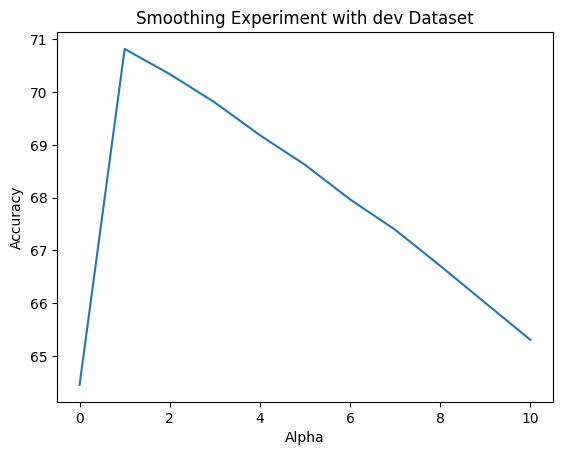

In [198]:
plt.figure()
plt.title('Smoothing Experiment with dev Dataset')
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.plot(dev_smoothing['alpha'], dev_smoothing['accuracy'])

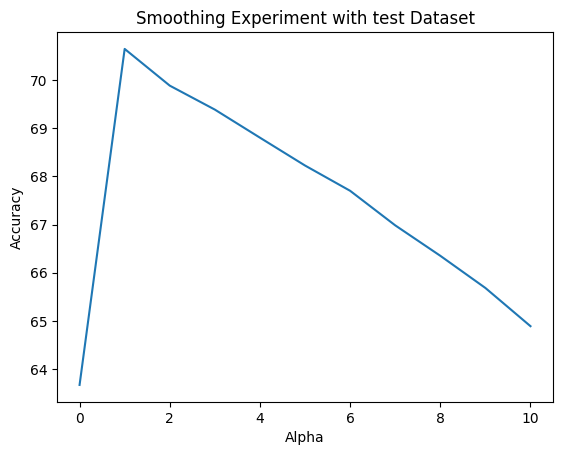

In [199]:
plt.figure()
plt.title('Smoothing Experiment with test Dataset')
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.plot(test_smoothing['alpha'], test_smoothing['accuracy'])

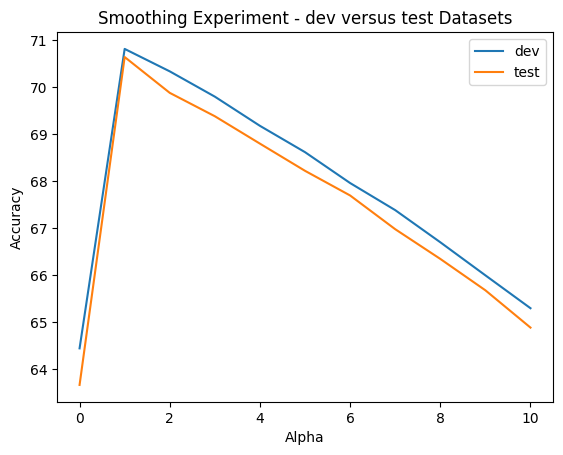

In [200]:
plt.figure()
plt.title("Smoothing Experiment - dev versus test Datasets")
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.plot(dev_smoothing['alpha'], dev_smoothing['accuracy'], label="dev")
plt.plot(test_smoothing['alpha'], test_smoothing['accuracy'], label="test")
plt.legend()

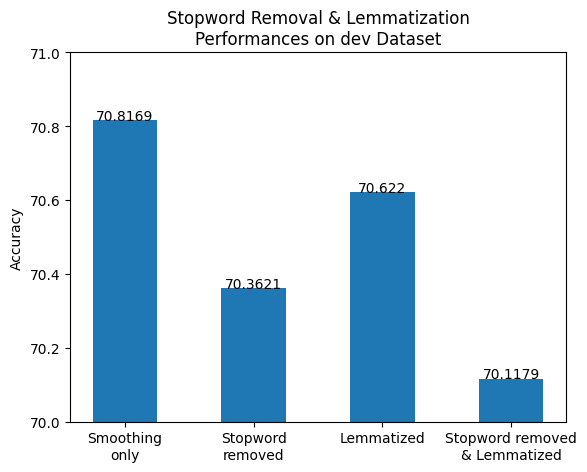

In [217]:
x_labels = ["Smoothing\nonly", "Stopword\nremoved", "Lemmatized", "Stopword removed\n& Lemmatized"]
accuracies = [70.8169, 70.3621, 70.6220, 70.1179]

plt.ylim(70, 71)
plt.title("Stopword Removal & Lemmatization\nPerformances on dev Dataset")
plt.ylabel("Accuracy")
plt.bar(x_labels, accuracies, width=0.5)
for x, y in zip(x_labels, accuracies):
  plt.text(x, y, str(y), ha="center")

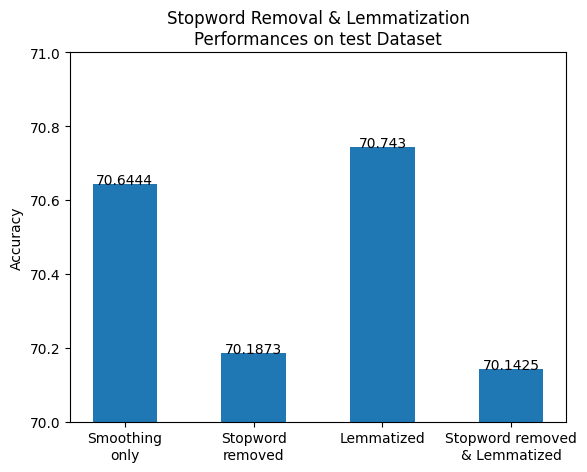

In [218]:
x_labels = ["Smoothing\nonly", "Stopword\nremoved", "Lemmatized", "Stopword removed\n& Lemmatized"]
accuracies = [70.6444, 70.1873, 70.7430, 70.1425]

plt.ylim(70, 71)
plt.title("Stopword Removal & Lemmatization\nPerformances on test Dataset")
plt.ylabel("Accuracy")
plt.bar(x_labels, accuracies, width=0.5)
for x, y in zip(x_labels, accuracies):
  plt.text(x, y, str(y), ha="center")

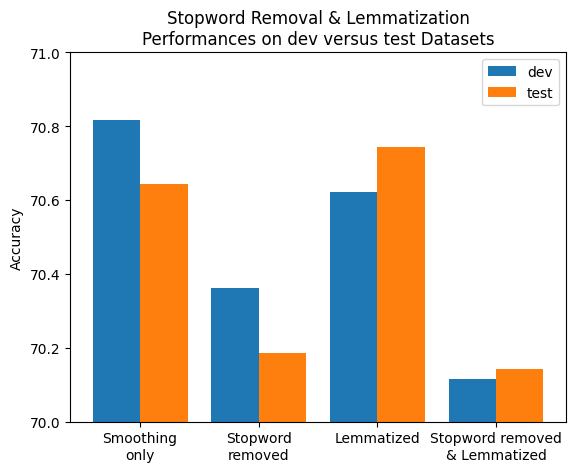

In [222]:
x_labels = ["Smoothing\nonly", "Stopword\nremoved", "Lemmatized", "Stopword removed\n& Lemmatized"]
x_axis = np.arange(len(x_labels))
dev_accuracies = [70.8169, 70.3621, 70.6220, 70.1179]
test_accuracies = [70.6444, 70.1873, 70.7430, 70.1425]

plt.ylim(70, 71)
plt.title("Stopword Removal & Lemmatization\nPerformances on dev versus test Datasets")
plt.xticks(x_axis, x_labels)
plt.ylabel("Accuracy")
plt.bar(x_axis - 0.2, dev_accuracies, width=0.4, label="dev")
plt.bar(x_axis + 0.2, test_accuracies, width=0.4, label="test")
plt.legend()

# Video Demo

In [22]:
import pandas as pd

def demo_test_accuracy(dataset, alpha):
  correct = 0
  results = []
  
  for index, row in dataset.loc[:,["subreddit", "tokens"]].iterrows():
    result = classify(row["tokens"], alpha)
    results.append(result)
    if row["subreddit"] == result:
      correct += 1
  
  accuracy = round(correct / len(dataset) * 100, 4)
  
  print(f"Results: {results}")
  print(f"Successfully classified {correct}/{len(dataset)} ({accuracy}%) correctly")


demo = { 
    "comment": [
        "They should go on a serious PR campaign that will target the politicians promoting the new laws. EU lawmakers have proved that they live in the Brussels bubble and only care about the public perception of their work. They are not going to care about the letter unless it damages their carreer",
        "Make that an army of tiny crabs. Hundreds of Excel files in local folders, each from a different analyst. Then name then V1, V2 and so on....",
        "Did an AI just made fun of us? And we were worried that AI would become sentient and kill us all. It's way worse people, it'll keeps us around and we'll spend eternity being the butt of its superintelligent jokes. And then it will make fun of us not understanding its jokes about 7 dimensional geometry.",
        "Fascinating to see a drop in usage at 95 before lots of usage at 100 - assuming this is a psychological thing where if you’re in the 90+ range you want to hit the 100 milestone instead of settling for 95",
        "Did they use machine learning to turn people into children?"
    ],
    "subreddit": [
        "MachineLearning",
        "datascience",
        "artificial",
        "datascience",
        "MachineLearning"
    ]
}
demo_df = pd.DataFrame(data=demo)

demo_df["comment"] = demo_df["comment"].apply(lambda c : c.lower())
demo_df["tokens"] = demo_df["comment"].apply(lambda c: tokenize(c))
demo_df["tokens"] = demo_df["tokens"].apply(lambda c: remove_punc_arr(c))
demo_df["tokens"] = demo_df["tokens"].apply(lambda c: lemmatize_tokens(c))

demo_test_accuracy(demo_df, alpha)


Results: ['MachineLearning', 'datascience', 'MachineLearning', 'datascience', 'MachineLearning']
Successfully classified 4/5 (80.0%) correctly
